In [1]:
from nimbro_vision_server.utils import load_image_b64, visualize_sam2_prompts, visualize_sam2

### Setup

In [2]:
import json
import requests

TOKEN = "super_secret_access_token"
headers = {
    "Authorization": f"Bearer {TOKEN}"
}

# make sure to start a sam2_realtime server and use the correct address, port and access token
server_base = "http://localhost:9000"

### Health

In [3]:
url = f"{server_base}/health"

response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    print("Data:", data)
else:
    print("Failed to retrieve health. Status code:", response.status_code)

Data: {'status': 'ok', 'cuda_available': True}


### Model Flavors

In [4]:
url = f"{server_base}/model_flavors"

response = requests.get(url, headers=headers)
if response.status_code == 200:
    data = response.json()
    print("Data:", data)
else:
    print("Failed to retrieve model flavors. Status code:", response.status_code)

Data: {'flavors': ['tiny', 'small', 'base', 'large']}


### Load Model

* Alternatively use "export SAM2_REALTIME_PRELOAD_FLAVOR=large" before starting the server.

In [5]:
url = f"{server_base}/load"
payload = {'flavor': 'large'}

response = requests.post(url, json=payload, headers=headers)

if response.status_code == 200:
    output = response.json()
    print(output)
else:
    print(f"Request failed with status code: {response.status_code}")

{'loaded_model': 'Model', 'flavor': 'large'}


### Load example

In [6]:
# load example image
image_b64 = load_image_b64('example_image.jpg')

# load a cached mmgroundingdino output so we have some bounding boxes
with open("example_artifact_mmgroundingdino.json", "r", encoding="utf-8") as f:
    box_annotations = json.load(f)

### Create Prompt

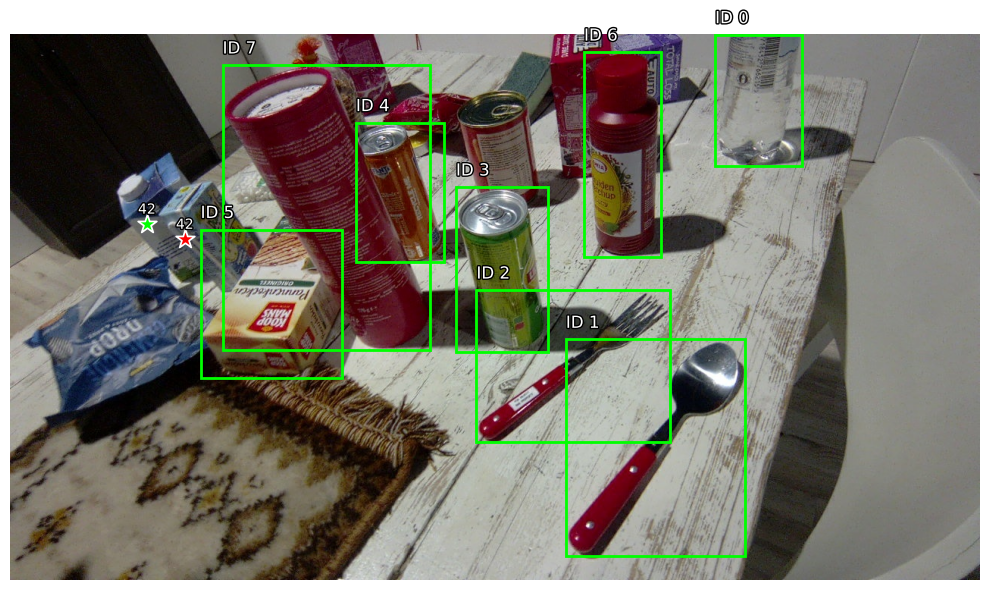

In [7]:
# take some box prompts from the previous mmgroundingdino detections 'object_id' is the track id that gets assigned to that prompt
box_prompts = [{'object_id': idx, 'bbox': det['box_xyxy']} for idx, det in enumerate(box_annotations['artifact']['detections'][0])]
# its also possible to prompt with points, lets add some to prompt for the milk carton, labels are 1 for positive and 0 for negative prompts
points_prompts = [{'object_id': 42, 'points': [[180,250], [230,270]], 'labels': [1, 0]}]
# combine as many prompts as desired to init/update the tracker
prompts = box_prompts + points_prompts
# construct payload for prompting the served model
update_payload = {'image': image_b64, 'prompts': prompts}
# visualize it
_ = visualize_sam2_prompts(update_payload)

### Update

* Note: currently always re-initializes the tracker, need to wait for SAM2 updates to propagate to realtime version

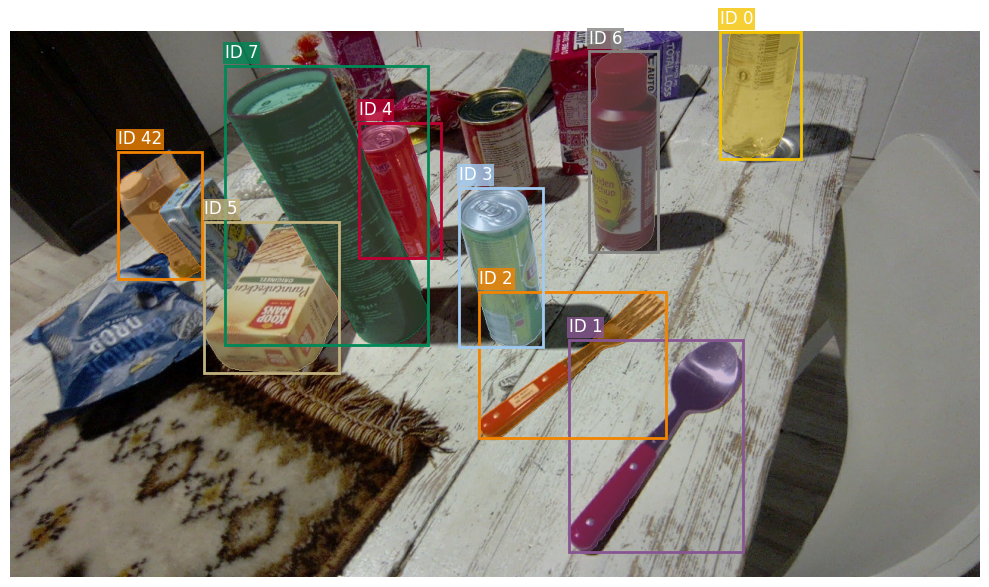

In [8]:
url = f"{server_base}/update"

response = requests.post(url, json=update_payload, headers=headers)

if response.status_code == 200:
    update_output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")

# visualize the results of the track update
_ = visualize_sam2(update_payload, update_output)

### Track

* Note that the image is the same, its more interesting to pass the next frames

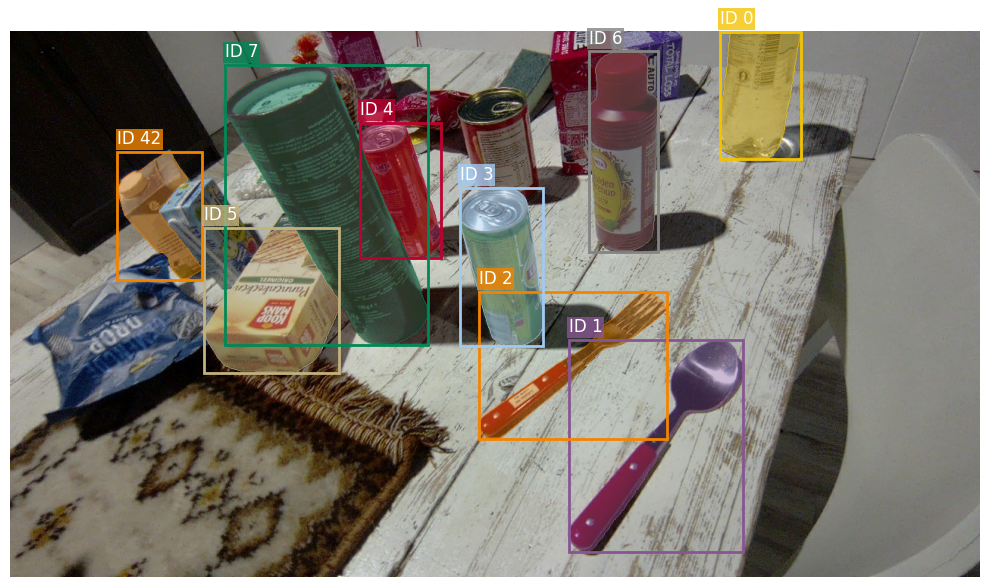

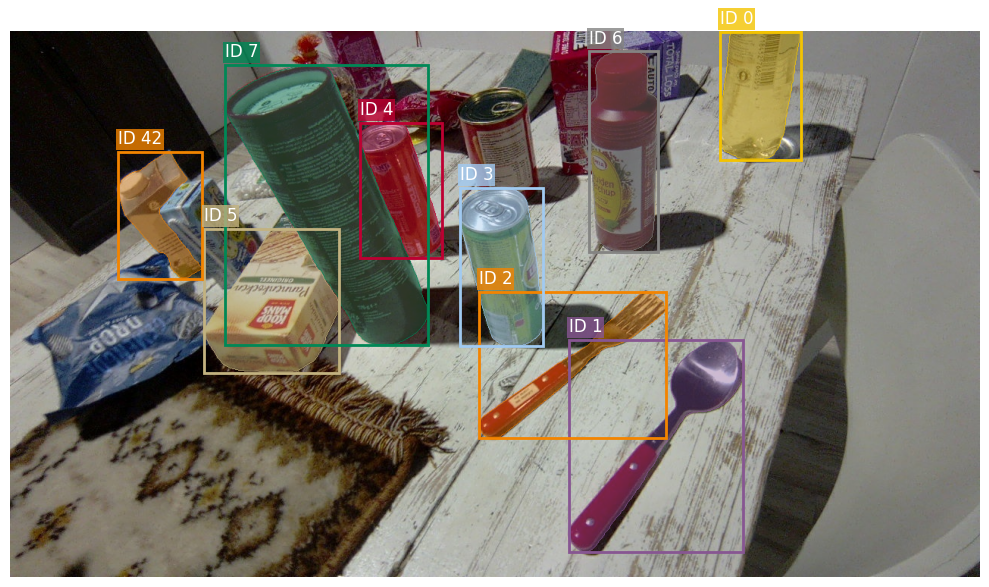

In [9]:
url = f"{server_base}/infer"
# we can pass multiple next frames and the tracker will process them sequentially
track_payload = {'images': [image_b64, image_b64]}

response = requests.post(url, json=track_payload, headers=headers)

if response.status_code == 200:
    track_output = response.json()
else:
    print(f"Request failed with status code: {response.status_code}")

# visualize the inference results
_ = visualize_sam2(track_payload, track_output)

### Reset

In [10]:
url = f"{server_base}/reset"

response = requests.post(url, headers=headers)

if response.status_code == 200:
    output = response.json()
    print(output)
else:
    print(f"Request failed with status code: {response.status_code}")

{'reset': True}


### Unload Model

In [11]:
url = f"{server_base}/unload"

response = requests.post(url, headers=headers)

if response.status_code == 200:
    output = response.json()
    print(output)
else:
    print(f"Request failed with status code: {response.status_code}")

{'unloaded': True}


In [12]:
#with open("example_artifact_sam2_realtime.json", "w", encoding="utf-8") as f:
#    json.dump(track_output, f, ensure_ascii=False, indent=4)